This notebook is to extract the distribution of TTC and Teq of each state/province from the inferred results

Replace the variable *PATH_TO_ROOT* to run the notebook 

In [1]:
import sys

PATH_TO_ROOT = 'C:/Users/walter/Desktop/git/AlphaBuilding-ResCommunity'
sys.path.insert(0,PATH_TO_ROOT)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=14, color='grey')
plt.rc('ytick', labelsize=14, color='grey')
plt.rc('legend', fontsize=16, loc='lower left')
plt.rc('savefig', dpi=700, bbox='tight')
%matplotlib inline

In [3]:
def generate_fig_name(fig_name):
    '''
    Generate the figure path and name
    To be used by plt.savefig function
    '''
    return '{}/docs/fig/{}'.format(PATH_TO_ROOT, fig_name)

## Read data

In [4]:
meta = pd.read_csv(f'{PATH_TO_ROOT}/data/Ecobee/meta_data.csv',usecols=['filename','Country', 'ProvinceState'])
ttc = pd.read_csv(f'{PATH_TO_ROOT}/data/Ecobee/result_cooling_2019.csv',
                  usecols = ['file', 'tTC_mean', 'tHeatGain_mean']).dropna()

In [5]:
data = pd.merge(meta, ttc, how='inner', left_on='filename', right_on='file')

In [6]:
data_clean = data[['Country','ProvinceState','tTC_mean','tHeatGain_mean']]
# Remove data points with unknown province
data_clean = data_clean[~data_clean['ProvinceState'].isna()] 

In [7]:
US_no = len(data_clean[data_clean['Country']=='US']['ProvinceState'].unique())
CA_no = len(data_clean[data_clean['Country']=='CA']['ProvinceState'].unique())
rest_no = len(data_clean['Country'].unique())-2
print('Number of states in US: {}\nNumber of states in CA: {}\nNumber of states in Others: {}'.format(
    US_no, CA_no, rest_no))

Number of states in US: 53
Number of states in CA: 8
Number of states in Others: 9


In [8]:
data_clean.groupby('Country').count()

,ProvinceState,tTC_mean,tHeatGain_mean
Country,,,
AR,1,1,1
AU,8,8,8
CA,7116,7116,7116
GB,2,2,2
GE,3,3,3
IR,3,3,3
IT,2,2,2
MX,7,7,7
PL,1,1,1


In [9]:
country_dict = {'US':'United States', 'CA':'Canada', 'AU':'Australia', 'GE':'Georgia',
                'IT':'Italy', 'MX':'Mexico', 'IR':'Iran', 'RU':'Russia',
                'GB':'United Kingdom','AR':'Argentina','PL':'Poland'}

In [10]:
## Plot

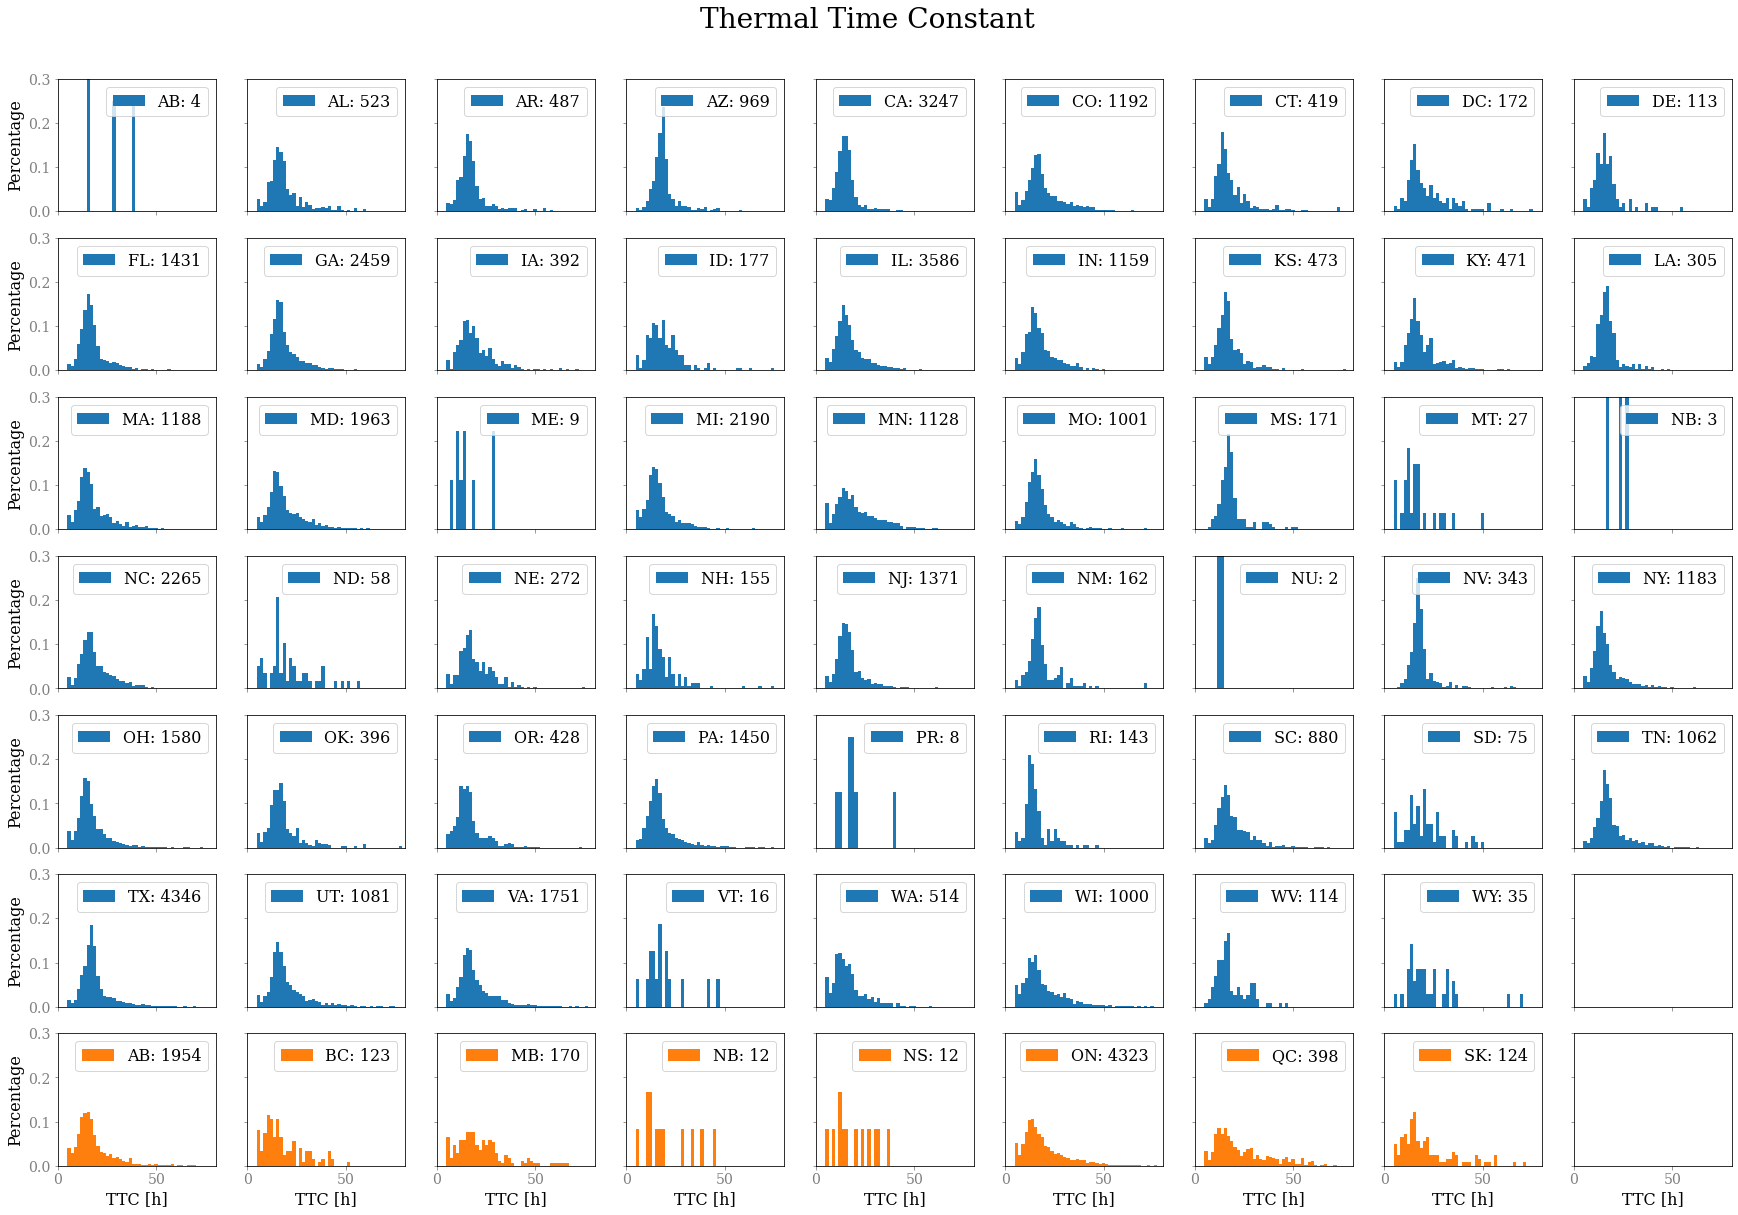

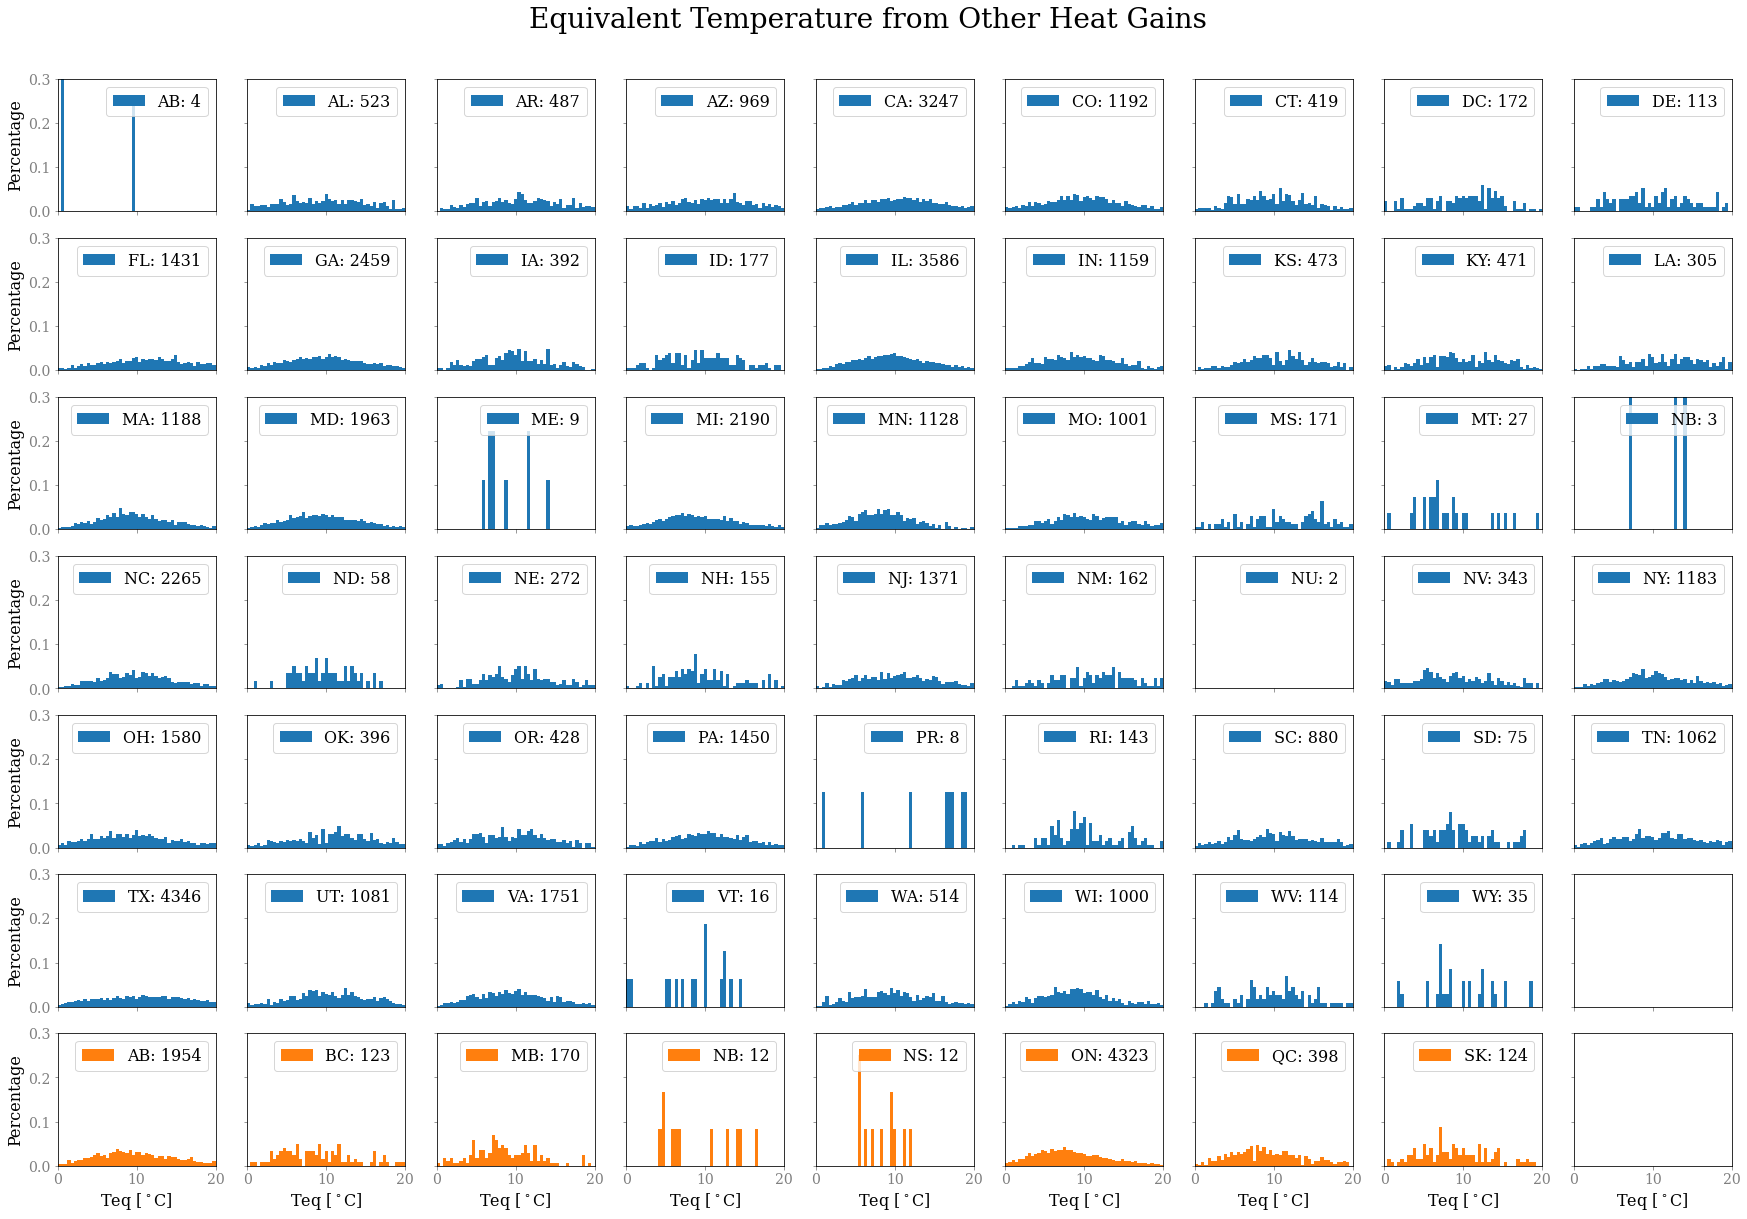

In [11]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_settings = {'tTC_mean':{'x-label':'TTC [h]','y-label':'Percentage',
                             'x-lim':[0,80],'y-lim':[0,0.3],
                             'title':'Thermal Time Constant'},
                 'tHeatGain_mean':{'x-label':'Teq [$^\circ$C]','y-label':'Percentage',
                                   'x-lim':[0,20],'y-lim':[0,0.3],
                                   'title':'Equivalent Temperature from Other Heat Gains'}}

for field in ['tTC_mean','tHeatGain_mean']:
    bins = np.linspace(plot_settings[field]['x-lim'][0],plot_settings[field]['x-lim'][1],50)
    fig, axs = plt.subplots(7, 9, figsize=(30,20))
    # plot US states
    i=0
    data_us = data_clean[data_clean['Country']=='US']
    us_states = np.sort(data_us['ProvinceState'].unique())
    for state in us_states:
        iRow = i//9
        iCol = i%9
        data_plot = data_us[data_us['ProvinceState']==state]
        sampleSize = data_plot.shape[0]
        data_array = data_plot[field].values
        axs[iRow,iCol].hist(data_array, bins, label='{}: {}'.format(state,sampleSize),color=colors[0],
                            weights=np.ones(len(data_array))/len(data_array))
        axs[iRow,iCol].legend(loc=1)
        # axs[iRow,iCol].sharey(axs[iRow,0])
        i += 1
    # plot CA states
    i=0
    data_ca = data_clean[data_clean['Country']=='CA']
    ca_states = np.sort(data_ca['ProvinceState'].unique())
    for state in ca_states:
        iRow = 6
        iCol = i%9
        data_plot = data_ca[data_ca['ProvinceState']==state]
        sampleSize = data_plot.shape[0]
        data_array = data_plot[field].values
        axs[iRow,iCol].hist(data_array, bins, label='{}: {}'.format(state,sampleSize),color=colors[1],
                            weights=np.ones(len(data_array))/len(data_array))
        axs[iRow,iCol].legend(loc=1)
        # axs[iRow,iCol].sharey(axs[iRow,0])
        i += 1
    
    for ax in axs.flat:
        ax.set(xlabel=plot_settings[field]['x-label'], ylabel=plot_settings[field]['y-label'],
               xlim=plot_settings[field]['x-lim'],ylim=plot_settings[field]['y-lim'])

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
    
    fig.suptitle(plot_settings[field]['title'],fontsize=28,y=0.93)
    plt.savefig(generate_fig_name('dist_{}.png'.format(field)))

In [12]:
TTC_sta = pd.concat([data_clean.groupby('ProvinceState')['tTC_mean'].mean(),
                     data_clean.groupby('ProvinceState')['tTC_mean'].std(),
                     data_clean.groupby('ProvinceState')['tTC_mean'].count()], axis=1)
TTC_sta.columns = ['mean', 'sd', 'count']
TTC_sta.index.rename('state', inplace=True)
TTC_sta.dropna(inplace=True)
TTC_sta.to_csv('TTC.csv')

In [13]:
Teq_sta = pd.concat([data_clean.groupby('ProvinceState')['tHeatGain_mean'].mean(),
                     data_clean.groupby('ProvinceState')['tHeatGain_mean'].std(),
                     data_clean.groupby('ProvinceState')['tHeatGain_mean'].count()], axis=1)
Teq_sta.columns = ['mean', 'sd', 'count']
Teq_sta.index.rename('state', inplace=True)
Teq_sta.dropna(inplace=True)
Teq_sta.to_csv('Teq.csv')